# Environmental Sound Classification using Deep Learning
## >> Data Preprocessing

In [ ]:
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.6 1

In [ ]:
!echo -e "1\n" | sudo update-alternatives --config python3

There are 2 choices for the alternative python3 (providing /usr/bin/python3).

  Selection    Path                Priority   Status
------------------------------------------------------------
* 0            /usr/bin/python3.8   2         auto mode
  1            /usr/bin/python3.6   1         manual mode
  2            /usr/bin/python3.8   2         manual mode

Press <enter> to keep the current choice[*], or type selection number: update-alternatives: using /usr/bin/python3.6 to provide /usr/bin/python3 (python3) in manual mode


In [ ]:
!python3 --version

Python 3.6.9


You may need to install librosa using pip as follows:

> **!pip install librosa==0.8.0**


In [ ]:
import os

import librosa
import numpy as np
import pandas as pd

from tqdm import tqdm

_US8k = 'US8K'
_ESC50 = 'ESC50'

---

## 0. Download and extract audio data


In [ ]:
dataset = _ESC50
USE_GOOGLE_COLAB = True

ROOT_FOLDER_NAME = f"Datasets"

if USE_GOOGLE_COLAB:
    # mount google drive
    from google.colab import drive 
    drive.mount('/content/gdrive')

%cd "/content/gdrive/My Drive/"
%mkdir -p $ROOT_FOLDER_NAME
%cd "/content/gdrive/My Drive/$ROOT_FOLDER_NAME"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive
/content/gdrive/My Drive/Datasets


In [ ]:
DOWNLOAD_DATASET = True
EXTRACT_DATASET = True

if dataset == _US8k:
  SOUND_DURATION = 4.0   # fixed duration of an audio excerpt in seconds
  DATASET_URL = "https://goo.gl/8hY5ER"

  if DOWNLOAD_DATASET:
      !wget $DATASET_URL

  if EXTRACT_DATASET:
      !tar xf 8hY5ER
      !rm 8hY5ER
elif dataset == _ESC50:
  SOUND_DURATION = 5.0   # fixed duration of an audio excerpt in seconds
  !pip install deeplake deeplake[audio] av
else:
  raise Exception(f"unknown dataset '{dataset}'")


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


---

In [ ]:
if dataset == _US8k:
  # set paths to the UrbanSound8K dataset and metadata file
  US8K_AUDIO_PATH = os.path.abspath('UrbanSound8K/audio/')
  US8K_METADATA_PATH = os.path.abspath('UrbanSound8K/metadata/UrbanSound8K.csv')
  # load the csv metadata file into a Pandas DataFrame structure
  us8k_metadata_df = pd.read_csv(US8K_METADATA_PATH,
                                usecols=["slice_file_name", "fold", "classID"],
                                dtype={"fold": "uint8", "classID" : "uint8"})

  us8k_metadata_df

elif dataset == _ESC50:
  import deeplake

  esc50_df = deeplake.load("hub://activeloop/esc50")
else:
  raise Exception(f"unknown dataset '{dataset}'")

hub://activeloop/esc50 loaded successfully.
This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/esc50


---

## 1. Feature Extraction


###### Extract a log-mel spectrogram for each audio file in the dataset and store it into a Pandas DataFrame along with its class and fold label.

In [ ]:
def compute_melspectrogram_with_fixed_length(audio, sampling_rate, target_time, debug=False):
    mult = (sampling_rate / 22050)
    HOP_LENGTH = int(512 * mult)        # number of samples between successive frames
    WINDOW_LENGTH = int(512 * mult)     # length of the window in samples
    N_MEL = 128                    # number of Mel bands to generate
    num_of_samples = int(sampling_rate / WINDOW_LENGTH * target_time)

    if debug:
      print(f"audio shape {audio.shape}")
    try:
        # compute a mel-scaled spectrogram
        melspectrogram = librosa.feature.melspectrogram(y=audio, 
                                                        sr=sampling_rate, 
                                                        hop_length=HOP_LENGTH,
                                                        win_length=WINDOW_LENGTH, 
                                                        n_mels=N_MEL)

        # convert a power spectrogram to decibel units (log-mel spectrogram)
        melspectrogram_db = librosa.power_to_db(melspectrogram, ref=np.max)
        
        melspectrogram_length = melspectrogram_db.shape[1]
        
        # pad or fix the length of spectrogram 
        if melspectrogram_length != num_of_samples:
            melspectrogram_db = librosa.util.fix_length(melspectrogram_db, 
                                                        size=num_of_samples, 
                                                        axis=1, 
                                                        constant_values=(0, -80.0))
            if debug:
              print(f'padding spectrogram (from {melspectrogram_length} to {num_of_samples})')
              print(f'spectrogram after padding {melspectrogram_db.shape[1]}')
    except Exception as e:
        print("\nError encountered while parsing files\n>>", e)
        return None 
    
    return melspectrogram_db

In [ ]:
features = []
sample_rate = 44100

classes = ('air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 'drilling', 'engine_idling', 
          'gun_shot', 'jackhammer', 'siren', 'street_music')

if dataset == _ESC50:
  for index, row in tqdm(enumerate(esc50_df[1:]), total=len(esc50_df)):
    audio = row.audio.numpy().flatten()
    label_text = row.labels.data()['text'][0]
    
    melspectrogram = compute_melspectrogram_with_fixed_length(audio, sample_rate, target_time=SOUND_DURATION, debug=True)
    label = row.labels.data()['value'][0]
    
    features.append([melspectrogram, label, label_text])
    
    break

else:
  for index, row in tqdm(us8k_metadata_df.iterrows(), total=len(us8k_metadata_df)):
    if index != 6:
      continue
    file_path = f'{US8K_AUDIO_PATH}/fold{row["fold"]}/{row["slice_file_name"]}'
    audio, sample_rate = librosa.load(file_path, duration=SOUND_DURATION, res_type='kaiser_fast')
    
    melspectrogram = compute_melspectrogram_with_fixed_length(audio, sample_rate, target_time=8.0, debug=True)
    label = row["classID"]
    label_text = classes[int(label)]
    
    features.append([melspectrogram, label])
    break

  0%|          | 0/2000 [00:08<?, ?it/s]

audio shape (220500,)
padding spectrogram (from 216 to 215)
spectrogram after padding 215


selected audio duration 5.0


<Figure size 2160x2160 with 0 Axes>

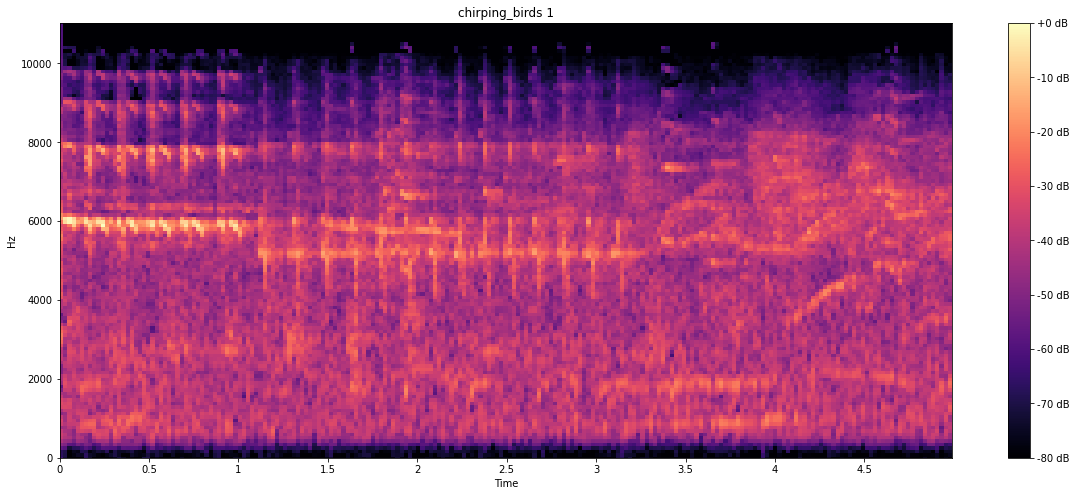

In [ ]:
import librosa.display
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 8]
print(f'selected audio duration {SOUND_DURATION}')
# .reshape((128,128))
plt.figure(figsize=(30,30))
fig, ax = plt.subplots()
img = librosa.display.specshow(melspectrogram, x_axis='time', y_axis='linear', ax=ax)
ax.set(title=f"{label_text} {label}")
fig.colorbar(img, ax=ax, format="%+2.f dB")

In [ ]:
features = []
sample_rate = 44100

print(f"Using dataset {dataset}:\ngenerating MFCCs")
# iterate through all dataset examples and compute log-mel spectrograms
if dataset == _US8k:
  classes = ('air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 'drilling', 'engine_idling', 
           'gun_shot', 'jackhammer', 'siren', 'street_music')
  for index, row in tqdm(us8k_metadata_df.iterrows(), total=len(us8k_metadata_df)):
      file_path = f'{US8K_AUDIO_PATH}/fold{row["fold"]}/{row["slice_file_name"]}'
      audio, sample_rate = librosa.load(file_path, duration=SOUND_DURATION, res_type='kaiser_fast')
      
      melspectrogram = \
          compute_melspectrogram_with_fixed_length(audio, sample_rate, target_time=SOUND_DURATION)
      label = row["classID"]
      label_text = classes[int(label)]
      
      features.append([melspectrogram, label, label_text])

elif dataset == _ESC50:
  for index, row in tqdm(enumerate(esc50_df), total=len(esc50_df)):
      audio = row.audio.numpy().flatten()
      label_text = row.labels.data()['text'][0]
      
      melspectrogram = \
        compute_melspectrogram_with_fixed_length(audio, sample_rate, target_time=SOUND_DURATION)
      label = row.labels.data()['value'][0]
      
      features.append([melspectrogram, label, label_text])
else:
  raise Exception(f"unknown dataset '{dataset}'")

print(f"(last) sample rate: {sample_rate}")
# convert into a Pandas DataFrame 
mfcc_df = pd.DataFrame(features, columns=["melspectrogram", "label", "text"])

Using dataset ESC50:
generating MFCCs


100%|██████████| 2000/2000 [05:49<00:00,  5.73it/s]

(last) sample rate: 44100


---

### Store the data

In [ ]:
# write the Pandas DataFrame object to .pkl file
WRITE_DATA = True

if WRITE_DATA:
  mfcc_df.to_pickle(f"{dataset}_df.pkl", protocol=4)

if dataset == _US8k:
  %rm -rf "/content/gdrive/My Drive/$ROOT_FOLDER_NAME/UrbanSound8K"